In [43]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../../Functions")
from GS_waves import select_freq_range, propagation_ew
from abtem.waves import PlaneWave
from Column_matching import (
    Bessel_transform,
    propagation_Bessel
)
import Generate_structure
from ase.visualize.plot import plot_atoms
from ase.io import read, write
from Complex_Gaussian import(
    Gaussian_function,
    Gaussian_in_focus,
    Gaussian_fitting
)
from Defocus_circle import generate_continious_phase
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy.optimize import minimize
from circle_fit import least_squares_circle

100%|██████████| 39/39 [00:11<00:00,  3.29it/s]


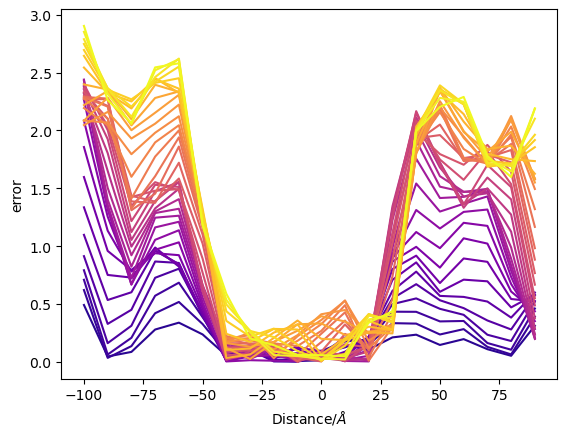

In [20]:
#Parameters to set
gmin = 0; gmax = 2; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
n_repeat = 2
cmap = plt.get_cmap("plasma")
thickness_range = np.arange(2, 41, 1)
total_error_rec = []
total_coeff_rec = []
for thickness in tqdm(thickness_range):
    theta = np.linspace(0, 2*np.pi, 100)
    cmap = plt.get_cmap("plasma")
    cut_factor = 0.01
    krange = np.linspace(gmin+cut_factor, gmax, length)
    #Generate isolated structure
    structure = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
    exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure).array),
                            gmin, gmax, sampling)
    exitwave_all = exitwave_all - 1
    m, n = exitwave_all.shape
    exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                            (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
    m, n = exitwave.shape
    x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
    results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                        x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
    fitted = Gaussian_fitting(results, krange, [0.01, 1])
    coeff = np.array(list(fitted.best_values.values()))
    x = np.arange(0, m, 1) - x0; y = np.arange(0, n, 1) - y0
    X, Y = np.meshgrid(x, y); R = np.sqrt(X**2 + Y**2)*sampling
    distance_range = np.arange(-100, 110, 10)
    error_rec = []
    coeff_rec = []
    for distance in distance_range:
        ew_prop_all = propagation_ew(exitwave_all, distance, sampling, energy)
        m, n = exitwave_all.shape
        ew_prop = ew_prop_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                            (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
        m, n = ew_prop.shape
        #ew_prop = propagation_ew(exitwave, distance, sampling, energy)
        results_prop, components_prop = Bessel_transform(ew_prop, sampling, gmin+cut_factor, gmax, length, 
                                        x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
        error = np.linalg.norm(np.abs(ew_prop-components_prop))
        error_rec.append(error)
        #results_prop, components_prop = propagation_Bessel(results, distance, gmin+cut_factor, gmax, length, sampling, energy, 
        #                                                exitwave.shape, x0, y0)
        fitted_prop = Gaussian_fitting(results_prop, krange, [0.01, 1])
        coeff_prop = np.array(list(fitted_prop.best_values.values()))
        coeff_rec.append(coeff_prop)
    coeff_rec = np.array(coeff_rec)
    error_rec = np.array(error_rec)
    plt.plot(distance_range[:-1], np.abs(np.diff(error_rec)), color=cmap(thickness/40))
    plt.xlabel(r"Distance/$\AA$")
    plt.ylabel("error")
    total_error_rec.append(error_rec)
    total_coeff_rec.append(coeff_rec)
plt.show()
total_coeff_rec = np.array(total_coeff_rec)
total_error_rec = np.array(total_error_rec)

In [23]:
total_coeff_rec.shape

(39, 21, 6)

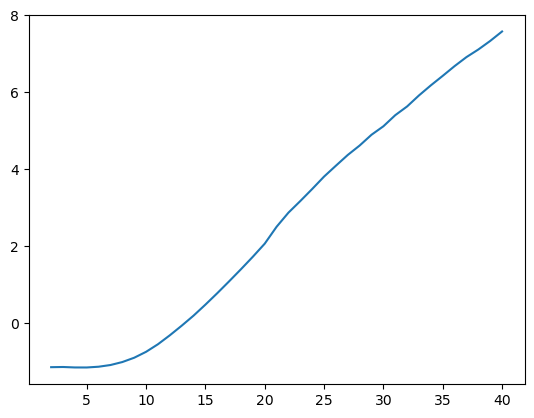

In [41]:
slope_rec = []
intercept_rec = []
for index, thickness in enumerate(thickness_range):
    #plt.plot(total_coeff_rec[index,:,3])
    res = LinearRegression().fit(distance_range.reshape(-1, 1),
                                 total_coeff_rec[index,:,3])    
    slope_rec.append(res.coef_[0])
    intercept_rec.append(res.intercept_)
slope_rec = np.array(slope_rec)
intercept_rec = np.array(intercept_rec)
plt.plot(thickness_range, intercept_rec/slope_rec)
plt.show()

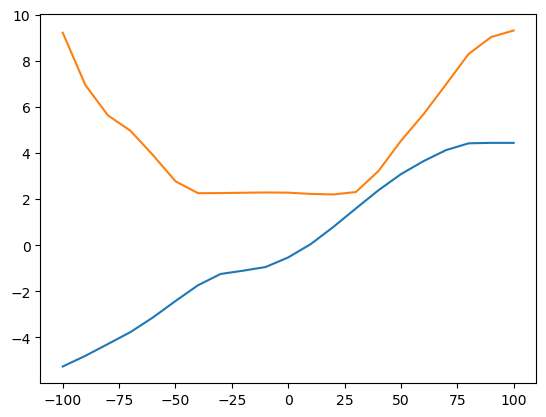

In [48]:
index_to_choose = 10
plt.plot(distance_range, total_coeff_rec[index_to_choose,:,3])
plt.plot(distance_range, total_error_rec[index_to_choose,:])
plt.show()

In [54]:
def defocus_coefficient(distance):
    ew_prop = propagation_ew(exitwave, distance, sampling, energy)
    m, n = ew_prop.shape
    x0, y0 = np.unravel_index(np.argmax(np.abs(ew_prop)), ew_prop.shape)
    results_prop, components_prop = Bessel_transform(ew_prop, sampling, gmin+cut_factor, gmax, length, 
                                       x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
    krange = np.linspace(gmin+cut_factor, gmax, length)
    fitted = Gaussian_fitting(results_prop, krange, [0.01, 1])
    coeff = np.array(list(fitted.best_values.values()))
    defocus_factor = coeff[3]
    return np.abs(defocus_factor)
res = minimize(defocus_coefficient, 10, method="BFGS")

print(res.x)

[-17.12998395]


In [7]:
error_rec.shape

(21,)

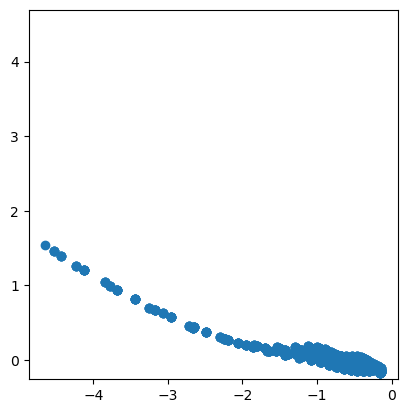

In [13]:
plt.scatter(np.real(exitwave), np.imag(exitwave))
plt.axis("square")
plt.show()

100%|██████████| 78/78 [00:47<00:00,  1.63it/s]


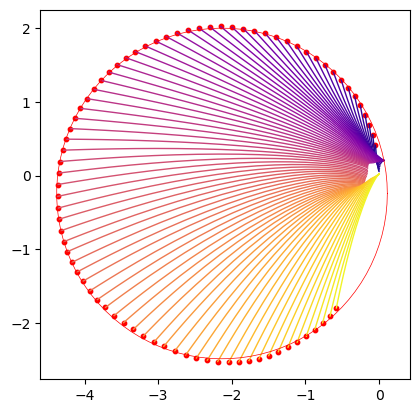

In [44]:
#Parameters to set
gmin = 0; gmax = 2; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
max_thickness = 80
thickness_range = np.arange(2, max_thickness, 1)
cmap = plt.get_cmap("plasma")
coeff_rec = []
for thickness in tqdm(thickness_range):
#    structure_1 = Generate_structure.generate_column("Al", thickness, a, a)
    n_repeat = 3
    structure_1 = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
    exitwave_1 = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_1).array),
                            gmin, gmax, sampling)
    m, n = exitwave_1.shape
    exitwave_1 = exitwave_1[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                            (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
    results, components = Bessel_transform(exitwave_1-1, sampling, gmin+0.01, gmax, length, x0=sampling/2, y0=sampling/2)
    krange = np.linspace(gmin+0.01, gmax, length)
    index_sel = np.where(np.logical_and(krange>=0.2,
                                        krange<=0.8))
    fitted = Gaussian_fitting(results, krange, [0.01, 1])
    coeff = np.array(list(fitted.best_values.values()))
    bg = coeff[-2] + 1j*coeff[-1]
    coeff_rec.append(coeff)
    #Fit line for the complex component
    a_re, a_im, b_re, b_im, c_re, c_im = coeff
    recover = Gaussian_function(krange, *coeff)
    #recover = Gaussian_in_focus(krange, a_re, a_im, b_re, c_re, c_im)
    #plt.plot(np.real(recover-bg), np.imag(recover-bg), linewidth=1, color=cmap(thickness/max_thickness))
    plt.plot(np.real(recover), np.imag(recover), linewidth=1, color=cmap(thickness/max_thickness))
    #plt.plot(krange, np.abs(results), color=cmap(thickness/max_thickness))
    #plt.plot(krange**2, np.log(np.abs(results)), color=cmap(thickness/max_thickness))
coeff_rec = np.array(coeff_rec)
#plt.plot(thickness_range, coeff_rec)
#plt.xlim([0, 0.5])
coeff_complex = coeff_rec[:,0] + 1j*coeff_rec[:,1]
coeff_bg = coeff_rec[:,-2] + 1j*coeff_rec[:,-1]
coeff_total = coeff_complex + coeff_bg
#plt.scatter(np.real(coeff_total), np.imag(coeff_total), color='r', s=10)
plt.scatter(np.real(coeff_total), np.imag(coeff_total), color='r', s=10)
coordinates_to_fit = np.vstack((np.real(coeff_total), np.imag(coeff_total))).T
xc, yc, r, sigma = least_squares_circle(coordinates_to_fit)
plt.plot(xc + r*np.cos(theta), yc + r*np.sin(theta), color='r', linewidth=0.5)
plt.axis("square")
plt.show()
#plt.plot(thickness_range, coeff_rec)
#plt.show()